In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
from data.scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
from scipy import sparse
from scipy.spatial.distance import cosine  # TODO may have to implement own maths formulas
from scipy.stats import entropy  # (kl-divergence) TODO may have to implement own maths formulas
from sklearn.linear_model import LogisticRegression  # TODO implement own classifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # TODO implement own tokenizer + count + tf-idf
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder  # TODO implement my own mapping
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# Load data from CSV
f_bodies = open('data/train_bodies.csv', 'r', encoding='utf-8')
csv_bodies = csv.DictReader(f_bodies)
bodies = []
for row in csv_bodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(bodies):
        bodies += [None] * (body_id + 1 - len(bodies))
    bodies[body_id] = row['articleBody']
f_bodies.close()
body_inverse_index = {bodies[i]: i for i in range(len(bodies))}

all_unrelated, all_discuss, all_agree, all_disagree = [], [], [], []  # each article = (headline, body, stance)

f_stances = open('data/train_stances.csv', 'r', encoding='utf-8')
csv_stances = csv.DictReader(f_stances)
for row in csv_stances:
    body = bodies[int(row['Body ID'])]
    if row['Stance'] == 'unrelated':
        all_unrelated.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'discuss':
        all_discuss.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'agree':
        all_agree.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'disagree':
        all_disagree.append((row['Headline'], body, row['Stance']))
f_stances.close()

In [3]:
# Split to train and validation
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))

train_unrelated = all_unrelated[:len(all_unrelated) * 9 // 10]
train_discuss = all_discuss[:len(all_discuss) * 9 // 10]
train_agree = all_agree[:len(all_agree) * 9 // 10]
train_disagree = all_disagree[:len(all_disagree) * 9 // 10]

val_unrelated = all_unrelated[len(all_unrelated) * 9 // 10:]
val_discuss = all_discuss[len(all_discuss) * 9 // 10:]
val_agree = all_agree[len(all_agree) * 9 // 10:]
val_disagree = all_disagree[len(all_disagree) * 9 // 10:]

print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))

	Unrltd	Discuss	 Agree	Disagree
All	 36545 	 8909 	 3678 	 840
Train	 32890 	 8018 	 3310 	 756
Valid.	 3655 	 891 	 368 	 84


In [4]:
train_all = train_unrelated + train_discuss + train_agree + train_disagree  # each article = (headline, body, stance)
random.Random(0).shuffle(train_all)
train_all = np.array(train_all)

val_all = val_unrelated + val_discuss + val_agree + val_disagree
random.Random(0).shuffle(val_all)
val_all = np.array(val_all)

print('Train (Total)', train_all.shape, '\tValidation (Total)', val_all.shape)
print(np.count_nonzero(train_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(train_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(train_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(train_all[:, 2] == 'disagree'))
print(np.count_nonzero(val_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(val_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(val_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(val_all[:, 2] == 'disagree'))

Train (Total) (44974, 3) 	Validation (Total) (4998, 3)
32890 	 8018 	 3310 	 756
3655 	 891 	 368 	 84


In [5]:
# Load GLoVe word vectors
f_glove = open("data/glove.6B.50d.txt", "rb")  # download from https://nlp.stanford.edu/projects/glove/
# also try if higher-dimension/higher-vocabulary GLoVe vectors work better
glove_vectors = {}
for line in tqdm(f_glove):
    glove_vectors[str(line.split()[0]).split("'")[1]] = np.array(list(map(float, line.split()[1:])))
# for key, value in glove_vectors.items():
#    print(key, value)
#    break
print(glove_vectors['glove'])

400000it [00:10, 38805.31it/s]


[-1.2879   -0.14538  -0.016613  1.1387    1.1317    0.20705  -0.47351
  0.15898   0.67879   0.2382    0.11621   0.26053  -0.8379    1.1232
  0.31469  -0.47904  -0.33717  -0.34492  -0.72053  -1.0543   -0.58476
 -0.42184  -0.56977  -1.1697   -0.50389  -1.4706   -0.22005   1.1314
  1.0829   -1.5477    0.77931  -0.22865   0.33369   0.52067   0.22109
  1.1267    0.11704   1.1647    0.5875   -0.079243  0.022386  0.90118
 -0.37459   0.82637  -0.41061  -0.95039   0.44121  -0.58558   0.12594
 -0.71778 ]


In [6]:
# Corpus of article bodies and headlines in training dataset
corpus = np.r_[train_all[:, 1], train_all[:, 0]]  # 0 to 44973 are bodies, 44974 to 89943 are headlines

In [7]:
# Convert documents in training set to tf-idf form, to learn idf weights
tf_idf_vec = TfidfVectorizer(stop_words='english')
tf_idf = tf_idf_vec.fit_transform(corpus)
# print(tf_idf[0])
print(tf_idf.shape)  # (2 x no of docs, no of words)

(89948, 23026)


In [31]:
# Create index of column indices in tf_idf -> word
col_to_word = {i[1]: i[0] for i in tf_idf_vec.vocabulary_.items()}
print(list(col_to_word.items())[:5])

for i in range(10):
    col, word = list(col_to_word.items())[i]
    print(tf_idf_vec.idf_[col], word)

[(2031, 'attorney'), (17068, 'representing'), (12641, 'man'), (17930, 'says'), (16606, 'realized')]
4.937914237108265 attorney
6.371516689504744 representing
2.829725591661936 man
3.077986220335818 says
6.155094238863611 realized
7.103693213970424 inadvertently
4.788255744359086 recorded
4.0826617893226 audio
3.5469246976967193 michael
4.04575723238715 brown


In [9]:
# Function to convert a document to GloVe vectors, by computing tf-idf of each word * GLoVe of word / total tf-idf for document
def doc_to_glove(doc):
    doc_tf_idf = tf_idf_vec.transform([doc])
    # print(doc_tf_idf[:10])
    _, cols = doc_tf_idf[0].nonzero()
    doc_vector = np.array([0.0]*50)
    sum_tf_idf = 0
    for col in cols:
        word = col_to_word[col]
        if word in glove_vectors:
            # print(word, tf_idf[row, col], glove_vectors[word])
            doc_vector += glove_vectors[word] * doc_tf_idf[0, col]
            sum_tf_idf += doc_tf_idf[0, col]
    doc_vector /= sum_tf_idf
    return doc_vector
print(train_all[0,0])
print(doc_to_glove(train_all[0,0]))

Al Qaida hostage killed in raid
[ 1.40336204 -0.29713257  0.7824141  -0.10616852  0.67776405 -0.47418078
 -0.33211532  0.6853884   0.21276827 -0.10664191 -0.52306133 -0.79293934
 -0.65304449  0.41550822 -0.10478675 -0.51422262 -0.2272418  -0.27009657
 -0.5350907   1.21539526 -0.1567672   0.72943174  0.68802754  0.30311577
 -0.87958703 -1.83329878 -0.34384378 -0.36733531  0.39257938  0.2169434
  1.8812151  -0.48053857 -0.63673718 -0.26299464  0.64639425  0.27540962
 -0.09585047 -0.86191694 -0.64410558  0.46340416 -0.28346891  0.28893852
  0.27789503 -0.48971771  1.09979954 -0.52053643 -0.7945171   0.2771475
  0.05022954 -0.26508926]


In [10]:
# Compute cosine similarity of GLoVe vectors for all headline-body pairs
def cosine_similarity(doc):
    return 1.0 - cosine(doc_to_glove(doc[0]), doc_to_glove(doc[1]))

for i in range(10):
    # unrelated should have lower than rest
    print(cosine_similarity(train_all[i]), train_all[i, 2])

0.5535534809145892 unrelated
0.5282470466552575 unrelated
0.6890198898441906 unrelated
0.7059881583485804 unrelated
0.6767240091383729 unrelated
0.8597709774722934 discuss
0.515454696508182 unrelated
0.7553530329321586 unrelated
0.5750419646307645 unrelated
0.619126586785193 discuss


In [11]:
# Compute the KL-Divergence of language model (LM) representations of the headline and the body
eps = 0.1  # add a small value for every common word in the LM, as KL-divergence won't work if there are 0 values
def kl_divergence(doc):
    # Convert body and headline to bag of words representations
    vec = CountVectorizer(stop_words='english')
    vec_all = vec.fit_transform([doc[0], doc[1]])
    vec_headline = np.squeeze(np.array(vec_all[0].todense()))
    vec_body = np.squeeze(np.array(vec_all[1].todense()))
    
    # Compute a simple unigram LM of headline and body using bag of words / no. of words in doc
    lm_headline = (vec_headline + eps) / np.sum(vec_headline)
    lm_body = (vec_body + eps) / np.sum(vec_body)
    
    # Return KL-divergence of lm
    return entropy(lm_headline, lm_body)

for i in range(10):
    # unrelated should have lower than rest
    print(cosine_similarity(train_all[i]), train_all[i, 2])

0.5535534809145892 unrelated
0.5282470466552575 unrelated
0.6890198898441906 unrelated
0.7059881583485804 unrelated
0.6767240091383729 unrelated
0.8597709774722934 discuss
0.515454696508182 unrelated
0.7553530329321586 unrelated
0.5750419646307645 unrelated
0.619126586785193 discuss


In [12]:
# Other feature 1 - distinguish unrelated vs rest
def ngram_match(doc):
    # Returns how many times n-grams (up to 3-gram) that occur in the article's headline occur on the article's body.
    vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
    vec.fit([doc[0]])
    vec_body = vec.transform([doc[1]])
    return np.power((np.sum(vec_body) / len(doc[1])), 1 / np.e)
    
for i in range(10):
    # unrelated should have lower than rest
    print(ngram_match(train_all[i]), train_all[i, 2])

0.0 unrelated
0.0 unrelated
0.0 unrelated
0.0 unrelated
0.07112217117626672 unrelated
0.17053662451253543 discuss
0.07745040665550863 unrelated
0.0 unrelated
0.0 unrelated
0.14827452235042 discuss


In [13]:
# Other feature 2 - distinguish discuss vs agree/disagree
def body_polarity(doc):
    # TODO (should be lower for discuss compared to agree/disagree)
    pass

In [14]:
# Other feature 3 - distinguish agree vs disagree
sent_analyser = SentimentIntensityAnalyzer()

def sentiment_mismatch(doc):
    return np.absolute(sent_analyser.polarity_scores(doc[0])['compound'] - sent_analyser.polarity_scores(doc[1])['compound'])
# sentiment_mismatch doesn't do anything atm.. still predicts everything as discuss
# Values seem to be random (agree not neccesarily lower, disagree not neccesarily higher)
# Maybe use a feature based on no. of negative words similar to 'no's in the body? - more likely to be disagree
    
train_related = train_all[train_all[:, 2] == 'discuss']
for i in range(5):
    print(sentiment_mismatch(train_related[i]), train_related[i, 2])
train_agree = train_all[train_all[:, 2] == 'agree']
for i in range(5):
    # Should be lower
    print(sentiment_mismatch(train_agree[i]), train_agree[i, 2])
train_disagree = train_all[train_all[:, 2] == 'disagree']
for i in range(5):
    # Should be higher
    print(sentiment_mismatch(train_disagree[i]), train_disagree[i, 2])

0.7016 discuss
0.9956 discuss
0.9118 discuss
0.8504 discuss
0.128 discuss
0.2836000000000001 agree
0.10300000000000001 agree
0.10170000000000001 agree
1.036 agree
1.1878 agree
0.5766 disagree
0.9019 disagree
0.982 disagree
0.592 disagree
1.309 disagree


In [15]:
# Define function to convert (headline, body) to feature vectors for each document
ftrs = [cosine_similarity, kl_divergence, ngram_match]
def to_feature_array(doc):
    vec = np.array([0.0] * len(ftrs))
    for i in range(len(ftrs)):
        vec[i] = ftrs[i](doc)
    return vec

# Initialise x and y for train dataset
x_train = np.array([to_feature_array(doc) for doc in tqdm(train_all)])
print(x_train[:5])

le = LabelEncoder()
y_train = le.fit_transform(list(train_all[:, 2]))
print(y_train[:5])

100%|████████████████████████████████████████████████████████████████████████████| 44974/44974 [09:29<00:00, 78.98it/s]


[[0.55355348 1.86962794 0.        ]
 [0.52824705 1.60449225 0.        ]
 [0.68901989 1.4246976  0.        ]
 [0.70598816 1.87567355 0.        ]
 [0.67672401 0.98289503 0.07112217]]
[3 3 3 3 3]


[('g', 'agree'), ('r', 'disagree'), ('b', 'discuss'), ('y', 'unrelated')]


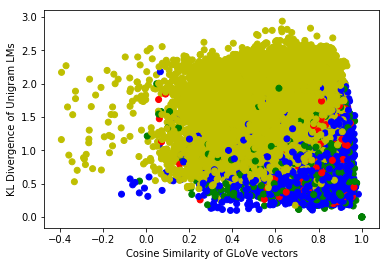

In [16]:
# Plot GLoVe distance vs KL-Divergence on a coloured scatter plot with different colours for each label
colours = np.array(['g', 'r', 'b', 'y'])
plt.scatter(list(x_train[:, 0]), list(x_train[:, 1]), c=colours[y_train])
plt.xlabel('Cosine Similarity of GLoVe vectors')
plt.ylabel('KL Divergence of Unigram LMs')
print([(colours[i], le.classes_[i]) for i in range(len(le.classes_))])
plt.show()

In [17]:
# Initialise x and y for validation dataset
x_val = np.array([to_feature_array(doc) for doc in tqdm(val_all)])
print(x_val[:5])

100%|██████████████████████████████████████████████████████████████████████████████| 4998/4998 [01:04<00:00, 77.88it/s]


[[0.24636734 1.43331701 0.        ]
 [0.8920077  0.56629963 0.21663166]
 [0.81490458 1.07943033 0.        ]
 [0.65236995 1.43794598 0.        ]
 [0.69811698 2.08539841 0.        ]]


In [18]:
# TODO implement linear/logistic regression classifier using these features. Optimise params on validation set
clf = LogisticRegression(C=1e2, random_state=0, multi_class='multinomial', solver='saga')
# clf = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)  # TODO temporary classifier
clf.fit(x_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
# Predict y for validation set
y_pred = clf.predict(x_val)
print(y_pred[:5])

[3 2 3 3 3]


In [20]:
# Prepare dataset format for score_submission in scorer.py
predicted = le.inverse_transform(y_pred)
body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

C:\Users\user\Anaconda3\envs\fnc\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
# Score using scorer.py:
test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    340    |    28     |
-------------------------------------------------------------
| disagree  |     0     |     0     |    72     |    12     |
-------------------------------------------------------------
|  discuss  |     1     |     0     |    820    |    70     |
-------------------------------------------------------------
| unrelated |     0     |     0     |    66     |   3589    |
-------------------------------------------------------------
ACCURACY: 0.882

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  2256.75  ||  913.75   ||  1820.5   ||



In [22]:
# save to .csv in the correct format (see data/scorer.py and data/train_stances.csv)
pred_tosave = np.array([('Headline','Body ID','Stance')] + [(val_all[i, 0], body_ids[i], predicted[i]) for i in range(len(val_all))])
gold_tosave = np.array([('Headline','Body ID','Stance')] + [(val_all[i, 0], body_ids[i], val_all[i, 2]) for i in range(len(val_all))])

# TODO does not work ATM (UnicodeDecodeError) - try 'python scorer.py val_gold.csv val_predicted.csv' in data folder
np.savetxt('data/val_predicted.csv', pred_tosave, delimiter=',', fmt='%s', encoding='utf-8', newline='\n')
np.savetxt('data/val_gold.csv', gold_tosave, delimiter=',', fmt='%s', encoding='utf-8', newline='\n')

In [23]:
# TODO analyse importance of each feature

In [24]:
GradientBoostingClassifier(n_estimators=200)
ACCURACY: 0.834  ||  1604.25  ||  No Added Features (just Cosine and KL-Divergence)
ACCURACY: 0.861  ||  1743.5   ||  'Raw' Unigram Match
ACCURACY: 0.861  ||  1743.5   ||  1+log(x) Unigram Match
ACCURACY: 0.860  ||  1743.5   ||  1-1/e^(x/2) Unigram Match
ACCURACY: 0.884  ||  1834.5   ||  x/len(body) Unigram Match
ACCURACY: 0.873  ||  1790.5   ||  log(x)/log(len(body)) Unigram Match
ACCURACY: 0.884  ||  1834.25  ||  (x/len(body))^1/e Unigram Match
    
LogisticRegression(C=1e5)
ACCURACY: 0.880  ||  1795.5   ||  (x/len(body))^1/e Unigram Match

LogisticRegression(C=1e2, multi_class='multinomial', solver='saga')
ACCURACY: 0.881  ||  1818.5   ||  (x/len(body))^1/e Unigram Match
ACCURACY: 0.882  ||  1819.5   ||  (x/len(body))^1/e 2-gram Match
ACCURACY: 0.882  ||  1820.5   ||  (x/len(body))^1/e 3-gram Match

SyntaxError: invalid syntax (<ipython-input-24-f0fe3618356e>, line 2)